🔄 Loading model...
✅ Model loaded! 80 classes ready

🔮 Predicting: 20190822_173921.jpg
🖼️  Using simple resize pipeline (training match)

📊 Raw prediction distribution (top 10):
  Aloevera            : 0.000
  Amla                : 0.000
  Amruthaballi        : 0.000
  Arali               : 0.001
  Astma_weed          : 0.000
  Badipala            : 0.000
  Balloon_Vine        : 0.000
  Bamboo              : 0.000
  Beans               : 0.000
  Betel               : 0.001

🎯 BEST PREDICTION: Lemon
📈 Confidence: 50.4%

📊 TOP 5 PREDICTIONS:
  🏆 1. Lemon                     50.4%
     2. Doddpathre                42.9%
     3. Tecoma                    1.2%
     4. Tulsi                     1.0%
     5. Gasagase                  0.8%


C:\Users\chinm\AppData\Local\Temp\ipykernel_51220\3844417255.py:160: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\chinm\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


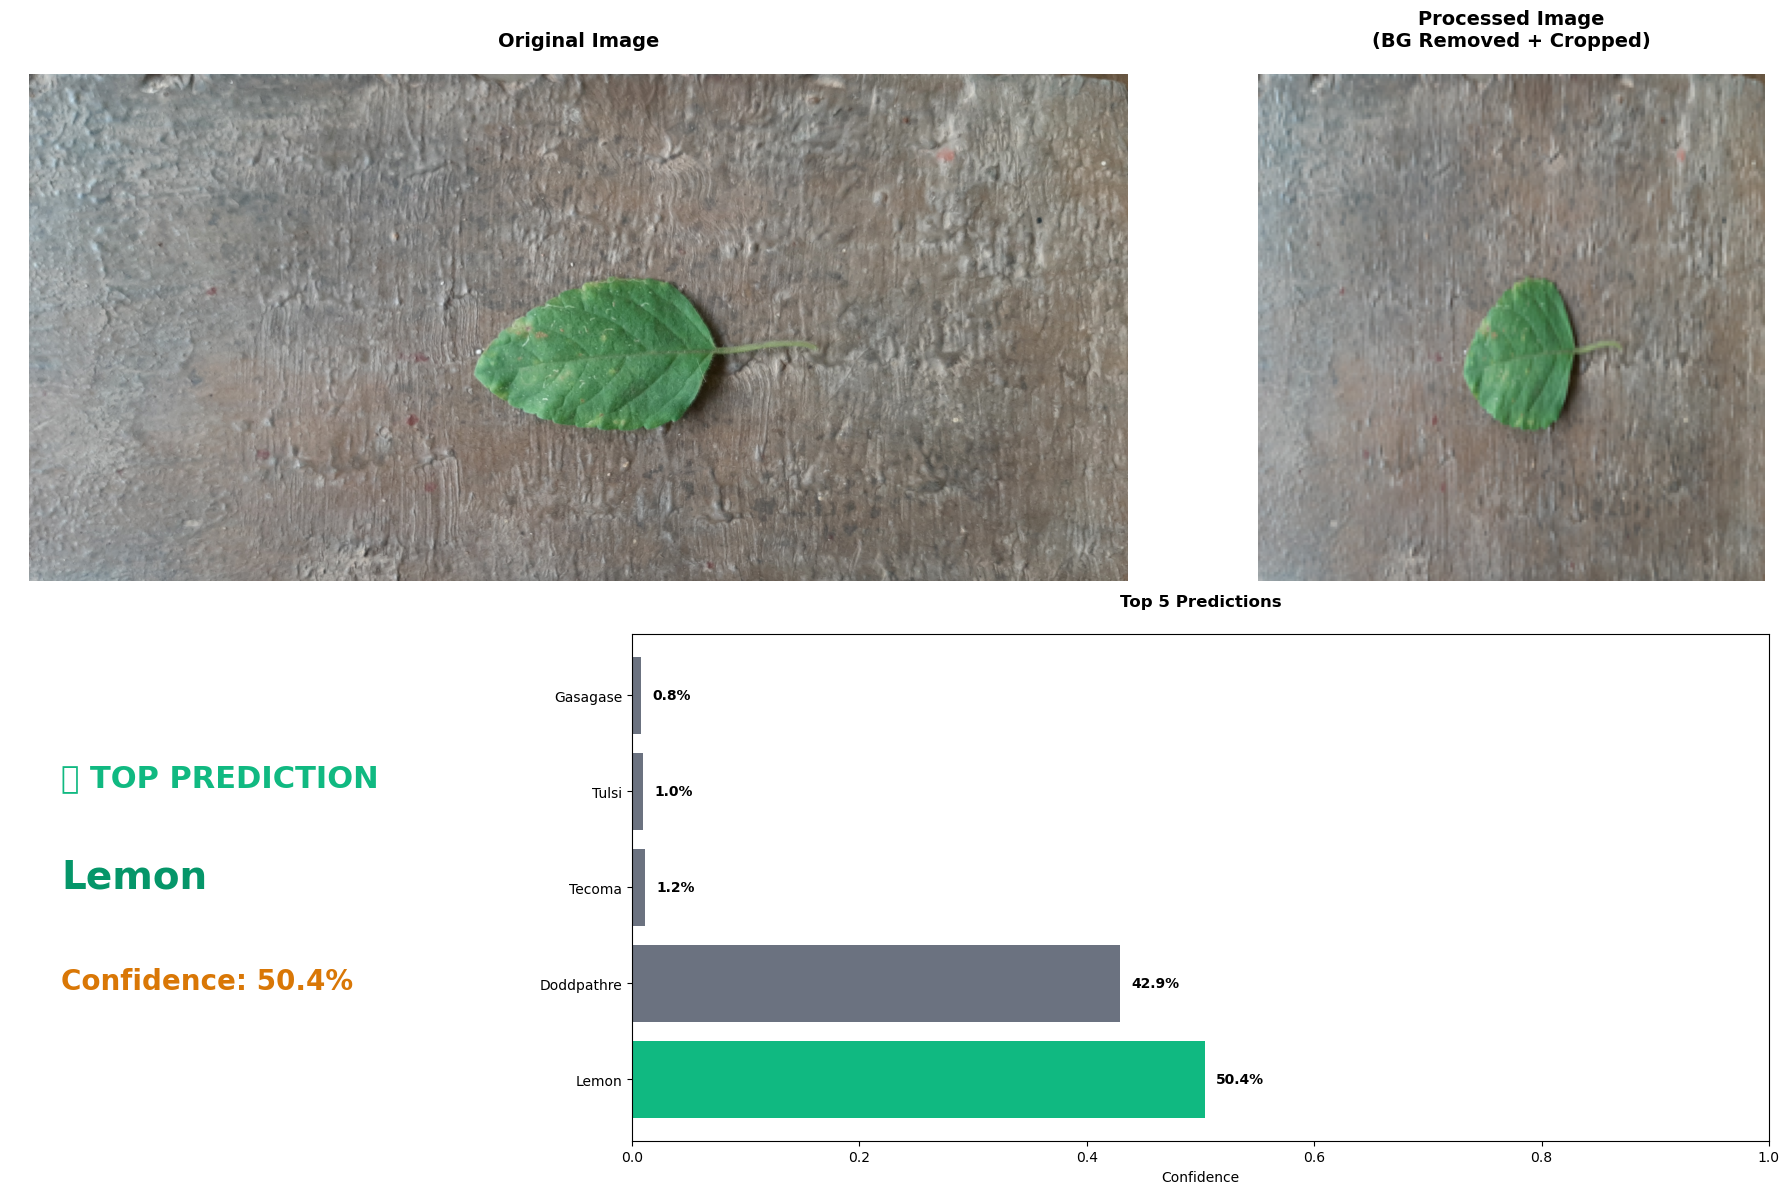

In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from rembg import remove
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input

class MedicinalLeafPredictor:
    def __init__(self, model_path):
        print("🔄 Loading model...")
        self.model = load_model(model_path, compile=False)
        self.model.build((None, 224, 224, 3))
        
        # Your exact 50 classes
        self.class_names =['Aloevera', 'Amla', 'Amruthaballi', 'Arali', 'Astma_weed', 'Badipala', 'Balloon_Vine', 'Bamboo', 'Beans', 'Betel', 'Bhrami', 'Bringaraja', 'Caricature', 'Castor', 'Catharanthus', 'Chakte', 'Chilly', 'Citron lime (herelikai)', 'Coffee', 'Common rue(naagdalli)', 'Coriender', 'Curry', 'Doddpathre', 'Drumstick', 'Ekka', 'Eucalyptus', 'Ganigale', 'Ganike', 'Gasagase', 'Ginger', 'Globe Amarnath', 'Guava', 'Henna', 'Hibiscus', 'Honge', 'Insulin', 'Jackfruit', 'Jasmine', 'Kambajala', 'Kasambruga', 'Kohlrabi', 'Lantana', 'Lemon', 'Lemongrass', 'Malabar_Nut', 'Malabar_Spinach', 'Mango', 'Marigold', 'Mint', 'Neem', 'Nelavembu', 'Nerale', 'Nooni', 'Onion', 'Padri', 'Palak(Spinach)', 'Papaya', 'Parijatha', 'Pea', 'Pepper', 'Pomoegranate', 'Pumpkin', 'Raddish', 'Rose', 'Sampige', 'Sapota', 'Seethaashoka', 'Seethapala', 'Spinach1', 'Tamarind', 'Taro', 'Tecoma', 'Thumbe', 'Tomato', 'Tulsi', 'Turmeric', 'ashoka', 'camphor', 'kamakasturi', 'kepala']
        print(f"✅ Model loaded! {len(self.class_names)} classes ready")
    
    def preprocess_image_pipeline1(self, img_path):
        """Original training pipeline (SIMPLE - for accuracy)"""
        img = Image.open(img_path).convert("RGB")
        img = img.resize((224, 224), Image.Resampling.LANCZOS)
        img_array = np.array(img, dtype=np.float32)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        return img, img_array
    
    def preprocess_image_pipeline2(self, img_path):
        """Advanced pipeline (BG removal - use if training used it)"""
        img = Image.open(img_path).convert("RGBA")
        removed_bg = remove(img)
        black_bg = Image.new("RGBA", removed_bg.size, (0, 0, 0, 255))
        merged = Image.alpha_composite(black_bg, removed_bg).convert("RGB")
        
        np_img = np.array(merged)
        mask = np.any(np_img != [0, 0, 0], axis=-1)
        if np.any(mask):
            coords = np.column_stack(np.where(mask))
            y_min, x_min = coords.min(axis=0)
            y_max, x_max = coords.max(axis=0)
            pad = 10
            cropped = merged.crop((
                max(0, x_min-pad), max(0, y_min-pad),
                min(merged.width, x_max+pad), min(merged.height, y_max+pad)
            ))
        else:
            cropped = merged
        
        img_resized = cropped.resize((224, 224), Image.Resampling.LANCZOS)
        img_array = np.array(img_resized, dtype=np.float32)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        return cropped, img_array
    
    def predict_leaf(self, img_path, use_bg_removal=True, top_k=5):
        """
        FIXED: Always returns TOP 5 predictions + accuracy diagnostics
        """
        try:
            original_img = Image.open(img_path).convert("RGB")
            
            # Try both pipelines for best accuracy
            if use_bg_removal:
                processed_img, img_array = self.preprocess_image_pipeline2(img_path)
                print("🖼️  Using BG removal pipeline")
            else:
                processed_img, img_array = self.preprocess_image_pipeline1(img_path)
                print("🖼️  Using simple resize pipeline (training match)")
            
            # Get predictions
            predictions = self.model.predict(img_array, verbose=0)[0]
            
            # ✅ ALWAYS GET TOP 5 (no threshold filtering)
            top_indices = np.argsort(predictions)[-top_k:][::-1]
            top_predictions = []
            
            print(f"\n📊 Raw prediction distribution (top 10):")
            for i in range(min(10, len(predictions))):
                print(f"  {self.class_names[i]:20s}: {predictions[i]:.3f}")
            
            # Format ALL top 5 results
            for rank, idx in enumerate(top_indices, 1):
                prob = float(predictions[idx])
                top_predictions.append({
                    'rank': rank,
                    'class': self.class_names[idx],
                    'confidence': prob,
                    'probability': f"{prob:.1%}"
                })
            
            result = {
                'success': True,
                'predicted_class': top_predictions[0]['class'],
                'confidence': top_predictions[0]['confidence'],
                'top_predictions': top_predictions,  # ALWAYS 5 items
                'total_classes': len(self.class_names),
                'original_image': original_img,
                'processed_image': processed_img,
                'all_probabilities': predictions.tolist(),  # Debug info
                'max_confidence': float(np.max(predictions))
            }
            return result
            
        except Exception as e:
            print(f"❌ Error: {e}")
            return {
                'success': False,
                'error': str(e),
                'original_image': original_img if 'original_img' in locals() else None,
                'processed_image': None,
                'top_predictions': []
            }

def visualize_prediction_enhanced(result):
    """Enhanced visualization with TOP 5 bar chart"""
    if not result['success']:
        print(f"❌ Error: {result.get('error')}")
        return
    
    fig = plt.figure(figsize=(18, 12))
    
    # Original vs Processed
    plt.subplot(2, 3, (1, 2))
    plt.imshow(result['original_image'])
    plt.title('Original Image', fontsize=14, fontweight='bold', pad=20)
    plt.axis('off')
    
    plt.subplot(2, 3, 3)
    plt.imshow(result['processed_image'])
    plt.title('Processed Image\n(BG Removed + Cropped)', fontsize=14, fontweight='bold', pad=20)
    plt.axis('off')
    
    # Main prediction
    plt.subplot(2, 3, 4)
    plt.axis('off')
    plt.text(0.1, 0.7, f"🎯 TOP PREDICTION", fontsize=22, fontweight='bold', 
             color='#10b981', transform=plt.gca().transAxes)
    plt.text(0.1, 0.5, result['predicted_class'], fontsize=28, fontweight='bold', 
             color='#059669', transform=plt.gca().transAxes)
    plt.text(0.1, 0.3, f"Confidence: {result['confidence']:.1%}", fontsize=20, 
             color='#d97706', fontweight='bold', transform=plt.gca().transAxes)
    
    # TOP 5 Bar Chart
    plt.subplot(2, 3, (5, 6))
    top5 = result['top_predictions']
    classes = [p['class'][:12] + '..' if len(p['class']) > 12 else p['class'] for p in top5]
    confidences = [p['confidence'] for p in top5]
    
    bars = plt.barh(range(5), confidences, color=['#10b981' if i==0 else '#6b7280' for i in range(5)])
    plt.yticks(range(5), classes)
    plt.xlabel('Confidence')
    plt.title('Top 5 Predictions', fontweight='bold', pad=20)
    plt.xlim(0, 1)
    
    # Add confidence % on bars
    for i, (bar, conf) in enumerate(zip(bars, confidences)):
        plt.text(conf + 0.01, i, f'{conf:.1%}', fontweight='bold', va='center')
    
    plt.tight_layout()
    plt.show()

# ===================================
# 🚀 USAGE - FIXED VERSION
# ===================================
if __name__ == "__main__":
    # Initialize
    predictor = MedicinalLeafPredictor("model_v2_medicinal_leaves.keras")
    
    # Test different images
    test_images = [
        "Medicinal Leaf dataset/Tulsi/20190822_173921.jpg",
        # Add more test images
    ]
    
    for img_path in test_images:
        if os.path.exists(img_path):
            print(f"\n{'='*70}")
            print(f"🔮 Predicting: {os.path.basename(img_path)}")
            print('='*70)
            
            # Try WITHOUT BG removal first (matches training)
            result_simple = predictor.predict_leaf(img_path, use_bg_removal=False)
            
            # Print detailed results
            print(f"\n🎯 BEST PREDICTION: {result_simple['predicted_class']}")
            print(f"📈 Confidence: {result_simple['confidence']:.1%}")
            print(f"\n📊 TOP 5 PREDICTIONS:")
            for pred in result_simple['top_predictions']:
                marker = '🏆' if pred['rank'] == 1 else '  '
                print(f"  {marker} {pred['rank']}. {pred['class']:<25s} {pred['probability']}")
            
            # Visualize
            visualize_prediction_enhanced(result_simple)
            
            # Save processed image
            
        else:
            print(f"❌ {img_path} not found")



🔄 Loading model...
✅ Model loaded! 80 classes ready

🔮 Predicting: green-leaf-isolated-on-white-260nw-1428004748.webp
🖼️  Using EXACT dataset preprocessing pipeline

📊 Raw prediction distribution (top 10):
  1. ashoka                   : 0.924
  2. Coffee                   : 0.046
  3. Neem                     : 0.010
  4. kepala                   : 0.008
  5. Tamarind                 : 0.002
  6. Curry                    : 0.002
  7. Mango                    : 0.001
  8. Citron lime (herelikai)  : 0.001
  9. Marigold                 : 0.001
  10. Eucalyptus               : 0.001

🎯 BEST PREDICTION: ashoka
📈 Confidence: 92.4%

📊 TOP 5 PREDICTIONS:
  🏆 1. ashoka                    92.4%
     2. Coffee                    4.6%
     3. Neem                      1.0%
     4. kepala                    0.8%
     5. Tamarind                  0.2%


C:\Users\chinm\AppData\Local\Temp\ipykernel_51220\1069539458.py:215: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\chinm\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


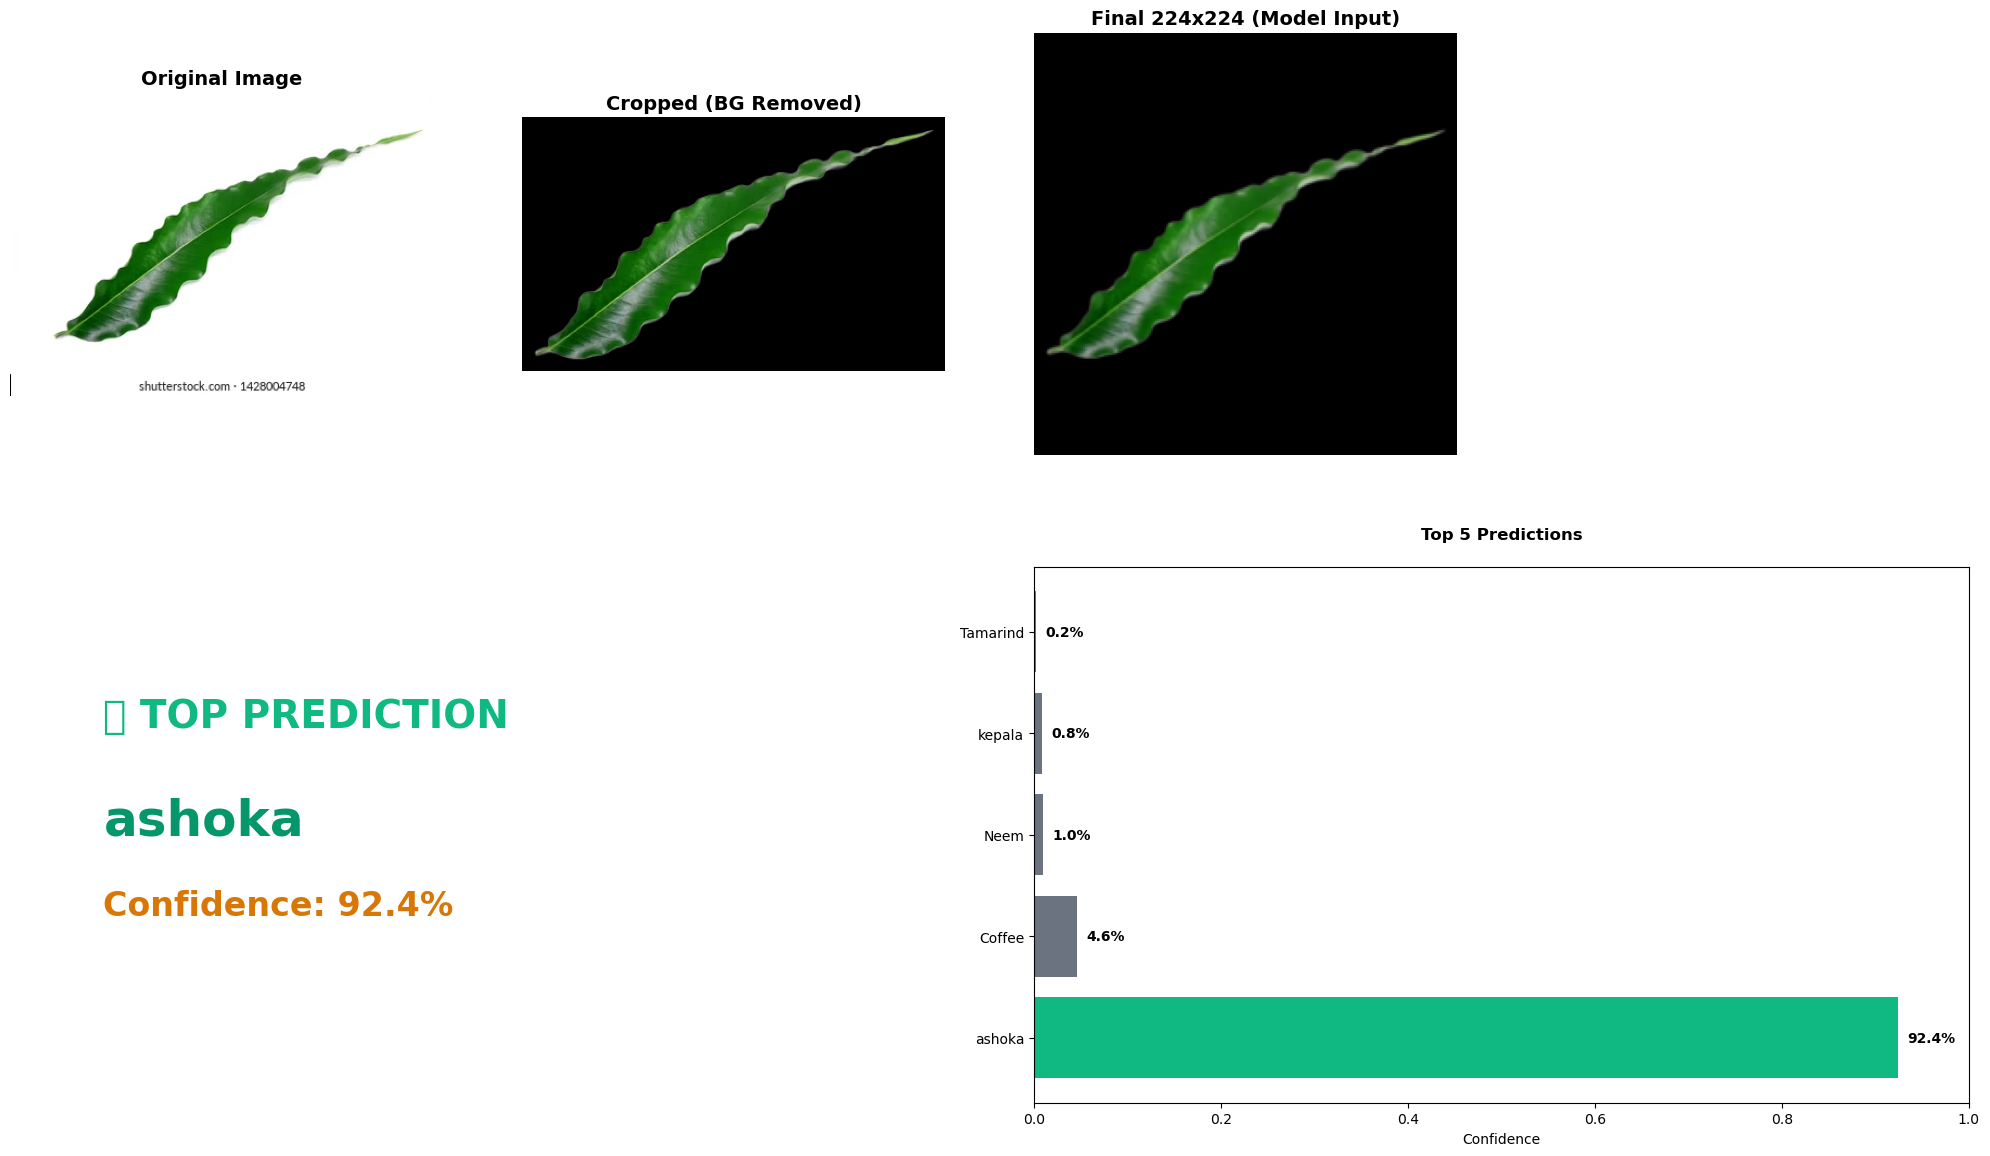

In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
from rembg import remove
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input

# Safety fixes
ImageFile.LOAD_TRUNCATED_IMAGES = True
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

class MedicinalLeafPredictor:
    def __init__(self, model_path):
        print("🔄 Loading model...")
        self.model = load_model(model_path, compile=False)
        self.model.build((None, 224, 224, 3))
        
        # Your exact 80 classes
        self.class_names = ['Aloevera', 'Amla', 'Amruthaballi', 'Arali', 'Astma_weed', 'Badipala', 'Balloon_Vine', 
                           'Bamboo', 'Beans', 'Betel', 'Bhrami', 'Bringaraja', 'Caricature', 'Castor', 
                           'Catharanthus', 'Chakte', 'Chilly', 'Citron lime (herelikai)', 'Coffee', 
                           'Common rue(naagdalli)', 'Coriender', 'Curry', 'Doddpathre', 'Drumstick', 'Ekka', 
                           'Eucalyptus', 'Ganigale', 'Ganike', 'Gasagase', 'Ginger', 'Globe Amarnath', 'Guava', 
                           'Henna', 'Hibiscus', 'Honge', 'Insulin', 'Jackfruit', 'Jasmine', 'Kambajala', 
                           'Kasambruga', 'Kohlrabi', 'Lantana', 'Lemon', 'Lemongrass', 'Malabar_Nut', 
                           'Malabar_Spinach', 'Mango', 'Marigold', 'Mint', 'Neem', 'Nelavembu', 'Nerale', 
                           'Nooni', 'Onion', 'Padri', 'Palak(Spinach)', 'Papaya', 'Parijatha', 'Pea', 'Pepper', 
                           'Pomoegranate', 'Pumpkin', 'Raddish', 'Rose', 'Sampige', 'Sapota', 'Seethaashoka', 
                           'Seethapala', 'Spinach1', 'Tamarind', 'Taro', 'Tecoma', 'Thumbe', 'Tomato', 'Tulsi', 
                           'Turmeric', 'ashoka', 'camphor', 'kamakasturi', 'kepala']
        print(f"✅ Model loaded! {len(self.class_names)} classes ready")
    
    def resize_with_padding(self, img, target_size=(224, 224)):
        """EXACT copy from your dataset preprocessing"""
        original_w, original_h = img.size
        target_w, target_h = target_size
        
        scale = min(target_w / original_w, target_h / original_h)
        new_w = int(original_w * scale)
        new_h = int(original_h * scale)
        
        # ✅ EXACT: BILINEAR from dataset
        resized = img.resize((new_w, new_h), Image.BILINEAR)
        
        padded = Image.new("RGB", target_size, (0, 0, 0))
        paste_x = (target_w - new_w) // 2
        paste_y = (target_h - new_h) // 2
        
        padded.paste(resized, (paste_x, paste_y))
        return padded
    
    def preprocess_image_exact_dataset(self, img_path):
        """🚀 EXACT replica of your dataset preprocessing pipeline"""
        # 1. Load image (EXACT dataset code)
        image = Image.open(img_path).convert("RGBA")
        image.load()
        
        # 2. Remove background (EXACT)
        removed_bg = remove(image)
        
        # 3. Force black background (EXACT)
        black_bg = Image.new("RGBA", removed_bg.size, (0, 0, 0, 255))
        merged = Image.alpha_composite(black_bg, removed_bg).convert("RGB")
        
        # 4. Crop to object (EXACT dataset logic)
        np_img = np.array(merged)
        mask = np.any(np_img != [0, 0, 0], axis=-1)
        coords = np.column_stack(np.where(mask))
        
        if coords.size == 0:
            raise ValueError("No plant detected after background removal")
        
        y_min, x_min = coords.min(axis=0)
        y_max, x_max = coords.max(axis=0)
        
        # ✅ EXACT: 10px padding + bounds checking
        pad = 10
        cropped = merged.crop((
            max(0, x_min-pad), 
            max(0, y_min-pad), 
            min(merged.width, x_max+pad), 
            min(merged.height, y_max+pad)
        ))
        
        # 5. EXACT resize_with_padding from dataset
        final_image = self.resize_with_padding(cropped, (224, 224))
        
        # 6. EfficientNet preprocessing
        img_array = np.array(final_image, dtype=np.float32)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        
        return cropped, final_image, img_array
    
    def preprocess_image_simple(self, img_path):
        """Simple resize-only (if training didn't use BG removal)"""
        img = Image.open(img_path).convert("RGB")
        img = img.resize((224, 224), Image.Resampling.LANCZOS)
        img_array = np.array(img, dtype=np.float32)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        return img, img_array
    
    def predict_leaf(self, img_path, use_dataset_pipeline=True, top_k=5):
        """Enhanced prediction with exact dataset matching"""
        try:
            original_img = Image.open(img_path).convert("RGB")
            
            if use_dataset_pipeline:
                print("🖼️  Using EXACT dataset preprocessing pipeline")
                cropped_img, processed_img, img_array = self.preprocess_image_exact_dataset(img_path)
            else:
                print("🖼️  Using simple resize pipeline")
                processed_img, img_array = self.preprocess_image_simple(img_path)
                cropped_img = processed_img  # No separate crop
            
            # Get predictions
            predictions = self.model.predict(img_array, verbose=0)[0]
            
            # ✅ ALWAYS TOP 5 predictions
            top_indices = np.argsort(predictions)[-top_k:][::-1]
            top_predictions = []
            
            # Debug: Show top 10 raw probabilities
            print(f"\n📊 Raw prediction distribution (top 10):")
            top10_indices = np.argsort(predictions)[-10:][::-1]
            for i, idx in enumerate(top10_indices):
                print(f"  {i+1}. {self.class_names[idx]:25s}: {predictions[idx]:.3f}")
            
            # Format top 5 results
            for rank, idx in enumerate(top_indices, 1):
                prob = float(predictions[idx])
                top_predictions.append({
                    'rank': rank,
                    'class': self.class_names[idx],
                    'confidence': prob,
                    'probability': f"{prob:.1%}"
                })
            
            result = {
                'success': True,
                'predicted_class': top_predictions[0]['class'],
                'confidence': top_predictions[0]['confidence'],
                'top_predictions': top_predictions,
                'total_classes': len(self.class_names),
                'original_image': original_img,
                'cropped_image': cropped_img,
                'processed_image': processed_img,
                'all_probabilities': predictions.tolist()
            }
            return result
            
        except Exception as e:
            print(f"❌ Error: {e}")
            return {
                'success': False,
                'error': str(e),
                'original_image': original_img if 'original_img' in locals() else None,
                'top_predictions': []
            }

def visualize_prediction_enhanced(result):
    """Enhanced visualization with cropped + final images"""
    if not result['success']:
        print(f"❌ Error: {result.get('error')}")
        return
    
    fig = plt.figure(figsize=(20, 12))
    
    # Original
    plt.subplot(2, 4, 1)
    plt.imshow(result['original_image'])
    plt.title('Original Image', fontsize=14, fontweight='bold')
    plt.axis('off')
    
    # Cropped (after BG removal)
    plt.subplot(2, 4, 2)
    plt.imshow(result['cropped_image'])
    plt.title('Cropped (BG Removed)', fontsize=14, fontweight='bold')
    plt.axis('off')
    
    # Final processed
    plt.subplot(2, 4, 3)
    plt.imshow(result['processed_image'])
    plt.title('Final 224x224 (Model Input)', fontsize=14, fontweight='bold')
    plt.axis('off')
    
    # Main prediction
    plt.subplot(2, 4, (5, 6))
    plt.axis('off')
    plt.text(0.1, 0.7, f"🎯 TOP PREDICTION", fontsize=28, fontweight='bold', 
             color='#10b981', transform=plt.gca().transAxes)
    plt.text(0.1, 0.5, result['predicted_class'], fontsize=36, fontweight='bold', 
             color='#059669', transform=plt.gca().transAxes)
    plt.text(0.1, 0.35, f"Confidence: {result['confidence']:.1%}", fontsize=24, 
             color='#d97706', fontweight='bold', transform=plt.gca().transAxes)
    
    # TOP 5 Bar Chart
    plt.subplot(2, 4, (7, 8))
    top5 = result['top_predictions']
    classes_short = [p['class'][:15] + '...' if len(p['class']) > 15 else p['class'] for p in top5]
    confidences = [p['confidence'] for p in top5]
    
    bars = plt.barh(range(5), confidences, color=['#10b981' if i==0 else '#6b7280' for i in range(5)])
    plt.yticks(range(5), classes_short)
    plt.xlabel('Confidence')
    plt.title('Top 5 Predictions', fontweight='bold', pad=20)
    plt.xlim(0, 1)
    
    for i, (bar, conf) in enumerate(zip(bars, confidences)):
        plt.text(conf + 0.01, i, f'{conf:.1%}', fontweight='bold', va='center')
    
    plt.tight_layout()
    plt.show()

# ===================================
# 🚀 USAGE - FIXED VERSION
# ===================================
if __name__ == "__main__":
    # Initialize
    predictor = MedicinalLeafPredictor("model_v2_medicinal_leaves.keras")
    
    # Test images
    test_images = [
        "images for testing/green-leaf-isolated-on-white-260nw-1428004748.webp",
        # Add more test images here
    ]
    
    for img_path in test_images:
        if os.path.exists(img_path):
            print(f"\n{'='*80}")
            print(f"🔮 Predicting: {os.path.basename(img_path)}")
            print('='*80)
            
            # ✅ USE DATASET PIPELINE (matches your training data)
            result = predictor.predict_leaf(img_path, use_dataset_pipeline=True)
            
            # Print results
            print(f"\n🎯 BEST PREDICTION: {result['predicted_class']}")
            print(f"📈 Confidence: {result['confidence']:.1%}")
            print(f"\n📊 TOP 5 PREDICTIONS:")
            for pred in result['top_predictions']:
                marker = '🏆' if pred['rank'] == 1 else '  '
                print(f"  {marker} {pred['rank']}. {pred['class']:<25s} {pred['probability']}")
            
            # Visualize
            visualize_prediction_enhanced(result)
 
            # result['cropped_image'].save(f"cropped_{os.path.basename(img_path)}")
            # result['processed_image'].save(f"processed_{os.path.basename(img_path)}")
            # print(f"\n💾 Saved: cropped_ & processed_{os.path.basename(img_path)}")
        else:
            print(f"❌ {img_path} not found")
